# Local Non-convexity

In [1]:
import invertwin as ivt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## Virtual Radar
We use a basic radar model from invertwin 

In [2]:
radar = ivt.SimpleRadar()
range_bin = np.arange(1,257) * radar.range_resolution   

We define two function, processing using FFT and surrogate model, respectively.

In [3]:
def process_fft(distance):
    distance_tensor =torch.tensor([distance])#.cuda()
    intensity_tensor = torch.tensor([10000.0])#.cuda()
    gt_fft = radar.chirp(distance_tensor)
    gt_db = 20*torch.log10(torch.abs(gt_fft))
    return gt_fft, None,gt_db


def process_surrogate(distance):
    distance_tensor =torch.tensor([distance])#.cuda()
    intensity_tensor = torch.tensor([10000.0])#.cuda()
    gt_fft = ivt.range_surrogate(distance_tensor, torch.tensor([1]), torch.tensor(range_bin))
    return gt_fft, None,None

Target range profile (Ground Truth)

In [4]:
gt_fft, gt_sig,gt_db = process_fft(distance=3.1415926539)

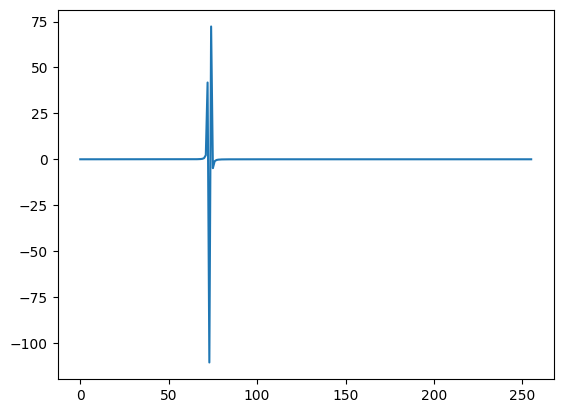

In [5]:
plt.plot(gt_fft.cpu().numpy().real)

We calculate all possible range x value to draw the loss landscape.

## Loss Landscape

In [6]:
def cal_loss_landsacpe(fn):
    n_sub_bin = 4
    max_iter = 256*n_sub_bin
    x_values = torch.linspace(0, radar.max_range, max_iter)
    loss_list = []
    loss_fn = nn.MSELoss()
    for v in x_values:
        pred_fft, pred_sig, pred_db = fn(v)
        loss = loss_fn(torch.abs(pred_fft), torch.abs(gt_fft))
        # loss = loss_fn(pred_fft.real, gt_fft.real) + loss_fn(pred_fft.imag, gt_fft.imag)
        # loss = loss_fn(torch.abs(pred_fft), torch.abs(gt_fft)) + loss_fn(torch.angle(pred_fft), torch.angle(gt_fft))
        loss_list.append(loss.cpu().numpy())
    return loss_list

## Visualization

In [7]:
def plot(loss_list,title=""):
    grad = torch.zeros(1024)
    for i in range(1, 1024):  # Start from 1 to avoid index -1
        grad[i] = loss_list[i] - loss_list[i-1]

    # Create a figure with three subplots in one row
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # First plot: loss_list from index 200 to 400
    axs[0].plot(loss_list[200:400])
    axs[0].set_title('Loss  Landscape')
    # axs[0].set_axis_off() 

    # Second plot: loss_list from index 160 to 220
    axs[1].plot(loss_list[160:220])
    axs[1].set_title('Loss  Landscape')
    # axs[1].set_axis_off() 
    # Third plot: grad from index 160 to 220
    axs[2].plot(grad[160:220], 'r', linewidth=2)
    axs[2].set_title('Gradient')
    # axs[2].set_axis_off() 
    # Add a centered title for the entire figure
    fig.suptitle(title, fontsize=16)
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Display the plots
    plt.show()

In [8]:
fft_loss_landscape = cal_loss_landsacpe(process_fft)
surrogate_loss_landscape = cal_loss_landsacpe(process_surrogate)

## Results

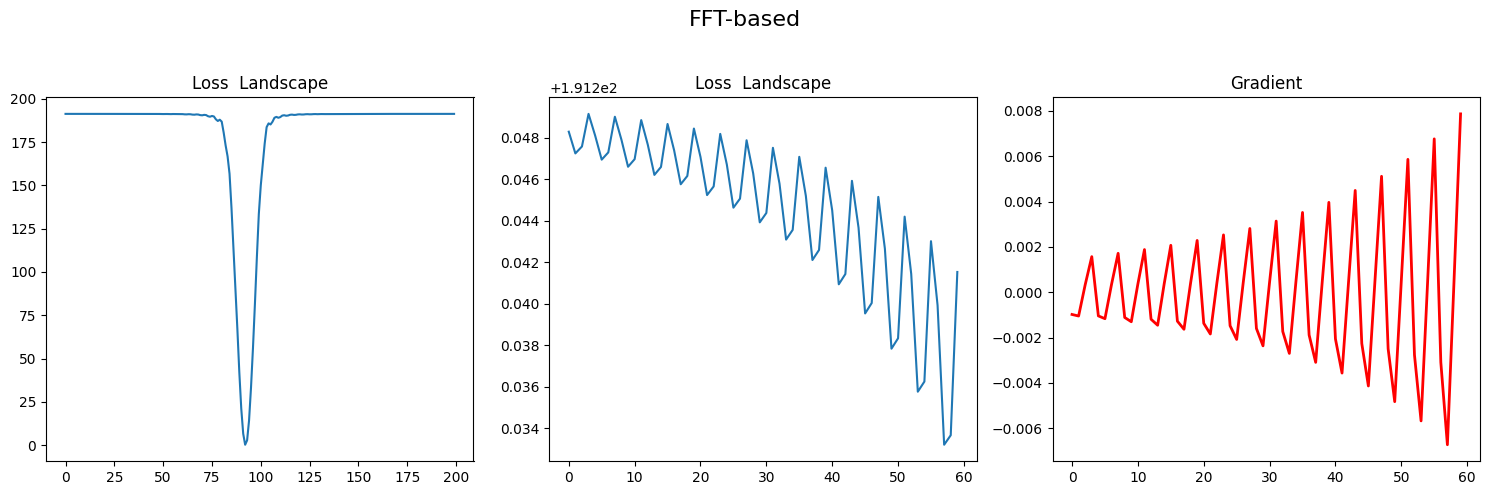

In [9]:
plot(fft_loss_landscape, "FFT-based")

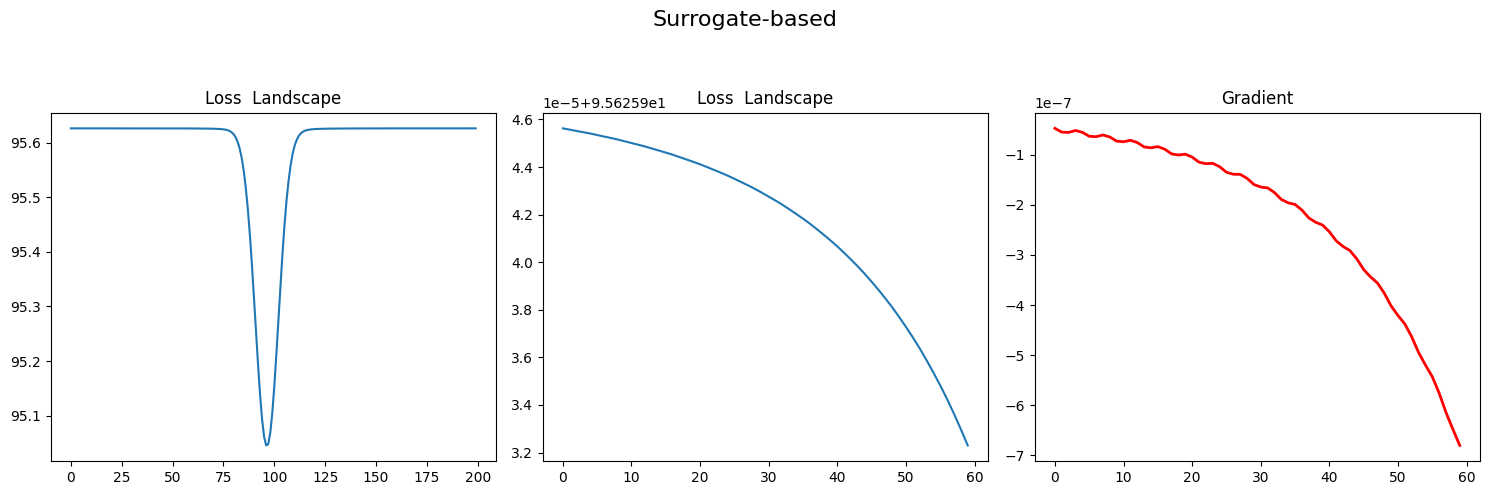

In [10]:
plot(surrogate_loss_landscape, "Surrogate-based")

Surrogate model provides smooth gradient and loss landscape for optimization.